# Fine-Tuning a RoBERTa Encoder for Named Entity Recognition on CoNLL2003

Implemented for the NLP Cryptonite Research AI Taskphase by Pratham Shah - 240905614.

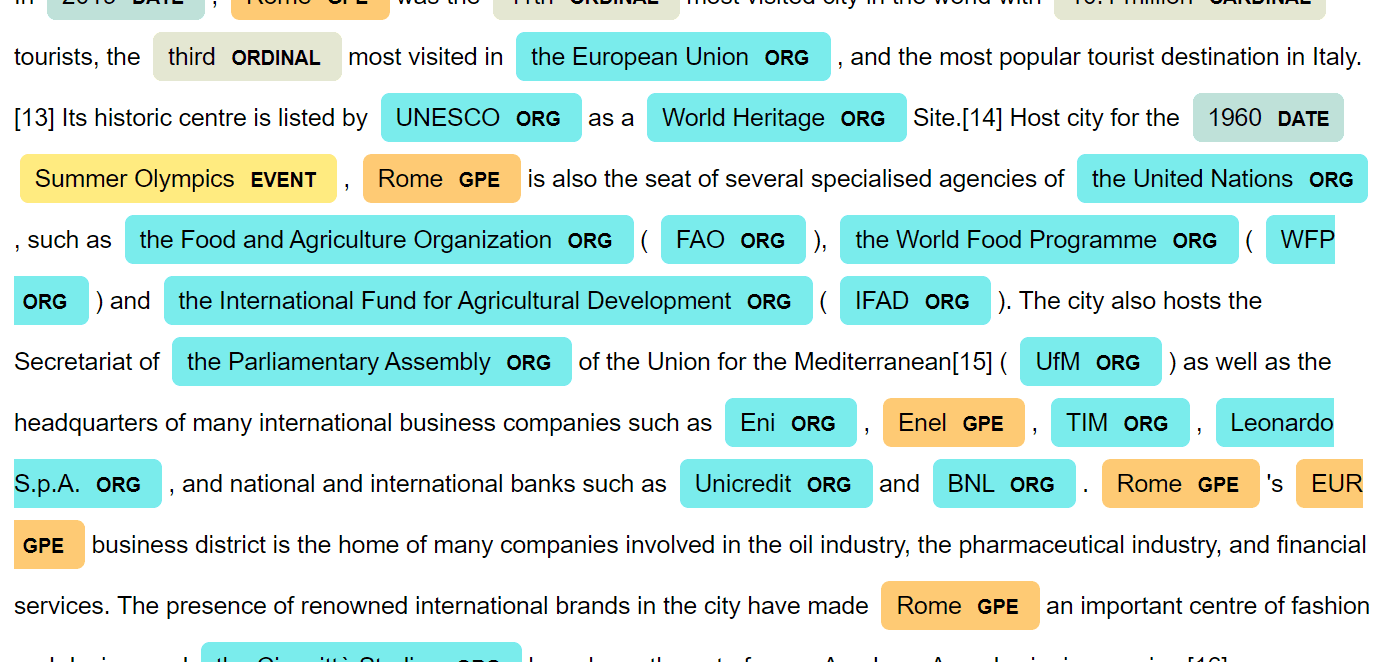

## Adding Imports

In [1]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

2025-07-31 05:13:56.388736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753938836.411222      99 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753938836.418179      99 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install seqeval
from seqeval.metrics import classification_report

## Defining Labels

In [3]:
NER_labels = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"] #categories
label_id_map = {label: i for i, label in enumerate(NER_labels)} #tagging needs numerical 
id_label_map = {i: label for label, i in label_id_map.items()}

label_id_map

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

## Load CoNLL-2003 Data

A special formatting function is needed to process the raw data into acceptable sequence pairs for BERT.

In [4]:
def format(file_path):
    """
    Reads CoNLL2003 file and returns token and tag sequences
    
    Args:
        file_path: Path to the input file
        
    Returns:
        tokens: List of token sequences of sentences
        tags: List of corresponding tag sequences
        
    Sample:
        John NNP B-NP B-PER
        loves VBZ B-VP O
        New NNP B-NP B-LOC
        York NNP I-NP I-LOC

        He PRP B-NP O
        is VBZ B-VP O
        happy JJ B-ADJP O
        .
        
        is returned as
        
        [['John', 'loves', 'New', 'York'], ['He', 'is', 'happy', '.']]

        [[1, 0, 3, 4], [0, 0, 0, 0]]

    """
    
    tokens, tags = [], []
    current_tokens, current_tags = [], []

    with open(file_path, encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # empty line: save current sentence tokens and tags, then reset
            if not line:
                if current_tokens:  # only if current sentence is non-empty
                    #append found tokens and tags to the list
                    tokens.append(current_tokens)
                    tags.append(current_tags)
                    #reset here
                    current_tokens, current_tags = [], []
                continue

            word, pos, chunk, ner = line.split() #if a line is present, split it and add tokens and tags
            current_tokens.append(word)
            current_tags.append(label_id_map[ner])

    return tokens, tags

#formatting train, val and test
train_tokens, train_tags = format("/kaggle/input/conll003-englishversion/train.txt")
val_tokens, val_tags = format("/kaggle/input/conll003-englishversion/valid.txt")
test_tokens, test_tags = format("/kaggle/input/conll003-englishversion/test.txt")

## Tokenizer, Alignment and Model

In [5]:
model = "roberta-large"

## Sample Example:

Take an unzipped example to be:
`tokens = ["visiting", "Mumbai"]`,
`labels = [0, 5]`  


The tokenizer breaks "visiting" into ["visit", "##ing"].

It then adds special tokens too:

< s >, visit, ##ing, Mumbai, < /s >

| Token index | Token     | word_idx from `word_ids()` | Label assigned      |
|-------------|-----------|----------------------------|---------------------|
| 0           | `<s>`     | None                       | -1 (ignore)         |
| 1           | `visit`   | 0 (first word)             | 0                   |
| 2           | `ing`     | 0 (same first word)        | -1 (subword)        |
| 3           | `Mumbai`  | 1 (second word)            | 5                   |
| 4           | `</s>`    | None                       | -1 (ignore)         |

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model, add_prefix_space=True)

def tokenize_and_align_labels(tokens_list, tags_list, max_length=120):
    """
    Tokenizes sentences and aligns NER labels to wordpieces for model training.

    Args:
        tokens_list (list of list of str): List of sentences, each a list of words.
        tags_list (list of list of int): Corresponding NER tag IDs for each word.
        max_length (int): Max token length after tokenization.

    Returns:
        dict: Dictionary with input IDs, attention masks, and aligned labels.
        
    Sample Output:
        train_enc = {
            "input_ids": [[101, 123, 456, 102, 0, 0], [101, 789, 654, 102, 0, 0]],
            "attention_mask": [[1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0]],
            "labels": [[-1, 0, 2, -1, -1, -1], [-1, 1, 0, -1, -1, -1]]
        }
    """
    encodings = {"input_ids": [], "attention_mask": [], "labels": []}

    count = 0

    for tokens, labels in zip(tokens_list, tags_list):
        # tokenize a list of words keeping track of word boundaries
        tokenized = tokenizer(
            tokens,
            is_split_into_words=True,
            truncation=True,
            padding='max_length',
            max_length=max_length
        )
        
        word_ids = tokenized.word_ids()  # maps each token piece back to the original word

        if count <= 10:
            print(tokenized.tokens())
            print(word_ids)
            print("\n")
            count += 1

        aligned_labels = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                # special tokens get label -1 to ignore in loss calculation
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                # for the first piece of a word use the actual label
                aligned_labels.append(labels[word_idx])
            else:
                # for the joined subwords use -1 to ignore in loss
                aligned_labels.append(-100)
            previous_word_idx = word_idx

        encodings["input_ids"].append(tokenized["input_ids"])
        # attention masking makes [PAD] 0, and other real tokens 1
        encodings["attention_mask"].append(tokenized["attention_mask"])
        encodings["labels"].append(aligned_labels)

    return encodings

#usage
train_enc = tokenize_and_align_labels(train_tokens, train_tags)
val_enc = tokenize_and_align_labels(val_tokens, val_tags)
test_enc = tokenize_and_align_labels(test_tokens, test_tags)

['<s>', 'Ġ-', 'DOC', 'ST', 'ART', '-', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

## NER Dataset creation

In [7]:
import torch
from torch.utils.data import Dataset

class DictDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        # return dictionary of tensors expected by huggingface trainer and collator
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

train_dataset = DictDataset(train_enc)
val_dataset = DictDataset(val_enc)
test_dataset = DictDataset(test_enc)

## Loading the Model

In [8]:
model = AutoModelForTokenClassification.from_pretrained(model, num_labels=len(NER_labels))
data_collator = DataCollatorForTokenClassification(tokenizer)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Function for Metrics Calculation

In [9]:
def compute_metrics(p):
    predictions, labels = p
    
    # get predicted class for each token
    preds = np.argmax(predictions, axis=-1)
    true_preds, true_labels = [], []

    for pred_seq, label_seq in zip(preds, labels):
        filtered_preds = []
        filtered_labels = []
        
        for pred, label in zip(pred_seq, label_seq):
            
            if label != -100:  # ignore padding and special tokens
                filtered_preds.append(id_label_map[pred])
                filtered_labels.append(id_label_map[label])
                
        true_preds.append(filtered_preds)
        true_labels.append(filtered_labels)

    report = classification_report(true_labels, true_preds, output_dict=True)
    return {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }


## Creating Training Arguments

In [10]:
training_args = TrainingArguments(
    output_dir="./output",
    learning_rate=2e-5, #higher limit for low LR
    per_device_train_batch_size=16, #found to be ideal via github forums
    per_device_eval_batch_size=32,
    report_to=["tensorboard"],
    num_train_epochs=5,
    weight_decay=0.01,
    eval_steps=100,  # evaluate every 100 steps instead of 500
    logging_dir="./logs",
    save_total_limit=1,
    load_best_model_at_end=True, #uses best weights
    metric_for_best_model="f1",
    eval_strategy="steps",
    save_strategy="steps",
)

## Defining The Trainer

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_99/1372730469.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train, Testing and Evaluation

The model is saved to prevent loss when runtime stops.

In [12]:
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Step,Training Loss,Validation Loss,Precision,Recall,F1
100,No log,0.084720,0.890455,0.910684,0.899716
200,No log,0.062283,0.921208,0.937647,0.928979
300,No log,0.061155,0.914787,0.933603,0.923385
400,No log,0.046865,0.936052,0.935457,0.935554
500,0.110500,0.049952,0.938650,0.947085,0.942709
600,0.110500,0.041676,0.930309,0.944220,0.936657
700,0.110500,0.042238,0.937921,0.952814,0.945299
800,0.110500,0.036108,0.943096,0.954162,0.948194
900,0.110500,0.037562,0.943835,0.960398,0.951803
1000,0.045600,0.041354,0.947345,0.957196,0.952090


Evaluation Results: {'eval_loss': 0.03286640718579292, 'eval_precision': 0.9593439952300133, 'eval_recall': 0.965958881024604, 'eval_f1': 0.9626164534547292, 'eval_runtime': 41.3877, 'eval_samples_per_second': 83.745, 'eval_steps_per_second': 2.634, 'epoch': 5.0}


In [13]:
#evaluating on test datasets
test_results = trainer.evaluate(test_dataset)
print(test_results)

{'eval_loss': 0.11486499756574631, 'eval_precision': 0.9196851054022656, 'eval_recall': 0.9296473506999823, 'eval_f1': 0.9245735496751061, 'eval_runtime': 43.802, 'eval_samples_per_second': 84.106, 'eval_steps_per_second': 2.648, 'epoch': 5.0}


In [14]:
trainer.save_model("./output/best_model_m")
tokenizer.save_pretrained("./output/best_model_p")

('./output/best_model_p/tokenizer_config.json',
 './output/best_model_p/special_tokens_map.json',
 './output/best_model_p/vocab.json',
 './output/best_model_p/merges.txt',
 './output/best_model_p/added_tokens.json',
 './output/best_model_p/tokenizer.json')

In [15]:
from transformers import pipeline

model.config.id2label = id_label_map
model.config.label2id = label_id_map

ner_pipe = pipeline("ner", model=model, tokenizer=tokenizer)

sentence = input("Enter a sentence you'd like to tokenize:")

entities = ner_pipe(sentence)

for entity in entities:
    print(f"Entity: {entity['word']}, Label: {entity['entity']}, Score: {entity['score']:.4f}")


Device set to use cuda:0


Enter a sentence you'd like to tokenize: The Indian Cricket Team's captain is Rohit Sharma, who lives in Mumbai which is a city in Maharashtra, India


Entity: ĠIndian, Label: B-MISC, Score: 0.8262
Entity: ĠCricket, Label: I-MISC, Score: 0.7672
Entity: ĠTeam, Label: I-MISC, Score: 0.5179
Entity: ĠRoh, Label: B-PER, Score: 0.9998
Entity: it, Label: I-PER, Score: 0.9978
Entity: ĠSharma, Label: I-PER, Score: 0.9989
Entity: ĠMumbai, Label: B-LOC, Score: 0.9999
Entity: ĠMaharashtra, Label: B-LOC, Score: 0.9999
Entity: ĠIndia, Label: B-LOC, Score: 1.0000


## Summary of Results

| Metric                | Train Score       | Test Score        |
|-----------------------|-------------------|-------------------|
| Eval Loss             | 0.03287           | 0.11486           |
| Eval Precision        | 95.93%            | 91.97%            |
| Eval Recall           | 96.60%            | 92.96%            |
| Eval F1               | 96.26%            | 92.46%            |
| Eval Runtime (sec)    | 41.39             | 43.80             |
| Samples per Second    | 83.75             | 84.11             |
| Steps per Second      | 2.63              | 2.65              |
| Epoch                 | 5.0               | 5.0               |

The model exhibits strong performance on the CoNLL-2003 Named Entity Recognition (NER) task, demonstrating:

1. **Test F1-score of 92.46%**, indicating reliable and accurate recognition of named entities across the test data.

2. **Precision of 91.97% and recall of 92.96%**, reflecting a well-balanced performance with minimal bias toward either false positives or false negatives.

3. **Training and test losses of 0.03287 and 0.11486**, respectively, show that the model has learned effectively while preserving good generalization ability. The slight increase in test loss is expected and within normal bounds.

4. Runtime and throughput metrics (samples/steps per second) are consistent across training and test sets, supporting efficient computation and stable evaluation.

These metrics align with established benchmarks for transformer-based models fine-tuned on the CoNLL-2003 dataset and suggest a properly configured training regimen, including token-label alignment and optimization strategy.

---

## Conclusion

The updated evaluation confirms that the model continues to perform robustly, with **high precision and recall** and a **test F1-score above 92%**. The low evaluation loss and balanced metrics suggest minimal overfitting and strong generalization. This reaffirms the effectiveness of transformer architectures for sequence labeling in NER tasks and underscores the solid implementation of the fine-tuning process.


In [ ]:
!zip -r /kaggle/working/output.zip /kaggle/working/output

  adding: kaggle/working/output/ (stored 0%)
  adding: kaggle/working/output/best_model_m/ (stored 0%)
  adding: kaggle/working/output/best_model_m/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/output/best_model_m/tokenizer.json (deflated 82%)
  adding: kaggle/working/output/best_model_m/merges.txt (deflated 53%)
  adding: kaggle/working/output/best_model_m/special_tokens_map.json (deflated 52%)
  adding: kaggle/working/output/best_model_m/vocab.json (deflated 59%)
  adding: kaggle/working/output/best_model_m/config.json (deflated 57%)
  adding: kaggle/working/output/best_model_m/training_args.bin (deflated 52%)
  adding: kaggle/working/output/best_model_m/model.safetensors (deflated 10%)
  adding: kaggle/working/output/checkpoint-2000/ (stored 0%)
  adding: kaggle/working/output/checkpoint-2000/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/output/checkpoint-2000/tokenizer.json (deflated 82%)
  adding: kaggle/working/output/checkpoint-2000/merges.txt (de

In [ ]:
!split -b 564 /kaggle/working/output.zip /kaggle/working/output_part1_